In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter , lfilter
from scipy.fftpack import fft, fftfreq
%matplotlib inline

from scipy import signal

In [131]:
'''  MODEL PARAMETERS '''

Cm = 100*pF                    # membrane capacitance
g_leak =10*nS                  # leak conductance
E_rest = -65*mvolt             # membrane rest potential
V_thresh = -52*mvolt           # membrane threshold potential
V_reset = -67*mvolt            # membrane reset potential 
tau_m = 10*ms                  # membrane time constant
tau_r = 1*ms                   # absolute refractory period

E_i  = -75*mvolt               # inhib. reversal potential
E_e  =  0*mvolt                # excit. reversal potential

tau_l = 1*ms                   # time delay 
tau_r_e  = 0.5*ms
tau_d_e  = 2*ms
tau_r_i  = 0.45*ms
#tau_d_i  = 1.2*ms

g_peak_e = 1*nS
#g_peak_i = 5*nS


N_inhib = 200      # number of inhibitory inter neurons in the network
N_excit = 800      # each inter neuron gets input from 800 excit. neurons.

In [132]:
def heaviside(t , t0):
    if t >= t0:
        return 1
    else:
        return 0  

In [133]:
def do_simulation(sim_dur, inp_freq, tau_d_i=1.2*ms, g_peak_i=5*nS):
    defaultclock.dt = 0.05*ms             # choose a particular time step
    timestep = 0.05*ms
    input_rate = (inp_freq/N_excit)*Hz       # total input to each neuron is 5 KHz
    alpha = 1 /ms

    ''' ----------  NEURON EQUATIONS ------------- '''

    eqs_model = '''
    dv/dt = (g_leak*(E_rest - v) + I_syn )/Cm : volt
    I_syn = I_ampa_exc + I_rec : amp
    I_ampa_exc = g_peak_e*(E_e - v)*s_ampa_tot : amp
    I_rec = g_peak_i*(E_i -v)*s_rec_tot : amp
    s_ampa_tot : 1
    s_rec_tot  : 1
    '''

    eqs_ampa = '''
    s_ampa_tot_post = w * s_ampa : 1 (summed)
    ds_ampa / dt = - s_ampa / tau_d_e + alpha * x * (1 - s_ampa) : 1 (clock-driven)
    dx / dt = - x / tau_r_e : 1 (clock-driven)
    w : 1
    '''
    eqs_pre_ampa = '''
    x += 1
    '''
    eqs_rec = '''
    s_rec_tot_post = w * s_rec : 1 (summed)
    ds_rec / dt = - s_rec / tau_d_i + alpha * y * (1 - s_rec) : 1 (clock-driven)
    dy / dt = - y / tau_r_i : 1 (clock-driven)
    w : 1
    '''
    eqs_pre_rec = '''
    y += 1
    '''
    #clip(gi, 0, g_peak_i)
    P = PoissonGroup(8400, rates=input_rate)

    G = NeuronGroup(N_inhib, eqs_model, threshold='v> V_thresh', reset='v = V_reset', method ='euler')

    # Excitatory Synapse Group
    S_excit = Synapses(P,G, model=eqs_ampa , on_pre= eqs_pre_ampa , delay = tau_l , method = 'euler')
    S_excit.connect(p=0.095)
    S_excit.w = 1.0
    # Inhibitory, Recurrent Synapse Group

    S_inhib = Synapses(G,G,model=eqs_rec , on_pre= eqs_pre_rec , delay = tau_l , method = 'euler')
    S_inhib.connect(condition='i!=j', p=0.2)
    # set inhib weights to 1.0 as well
    S_inhib.w = 1.0
    # Spike, State Monitors

    State_Mon = StateMonitor(G, 'v',record=True)
    Spike_Mon = SpikeMonitor(G)
    Rate_Mon = PopulationRateMonitor(G)

    # initialise at rest 
    G.v = E_rest
    print('Before v = %s' % G.v[0])
    run(sim_dur)
    print('After v = %s' % G.v[0])
    
    return (State_Mon, Spike_Mon, Rate_Mon)

In [20]:
def freq_analysis(time_vec, signal):
    
    # sampling freq.
    fs = 1000/(time_vec[1] - time_vec[0]) 

    # FFT & get power spectral density
    signalFFT = fft(signal-np.mean(signal))
    signalPSD = np.abs(signalFFT) ** 2
    # only up to fs/2, don't need mirror
    half = signalPSD[0:int(len(signalPSD)/2)]

    # create frequency-vector
    f = np.arange(0, fs/2, fs/(2*len(half)))

    return (f, half)
    #''''''''''
    #
    # Is the are a under the FFT normalized???
    #
    #''''''''''

def mean_spike(Spike_Mon, sim_time):
    spike=np.zeros(200)
    for j in range(0,200): 
        spike[j]=sum((Spike_Mon.i==j)*1)/(sim_time)
    return spike

def FFTplot(freq, signalFFT, ax):
    ax.plot(freq, signalFFT)
    ax.set_xlabel("$f$ [Hz]")
    ax.set_xlim([0, 500])
    
def plot_time(t, s, ax):
    ax.plot(t, s)
    ax.set_xlabel('ms')
    ax.set_ylabel('Membrane Potential (V)')
    ax.set_title('Network Population Activity')
    
def plot_firing_raster(Spike_Mon, ax):
    ax.plot(Spike_Mon.t/ms, Spike_Mon.i , '.k')
    ax.set_xlabel('ms')
    ax.set_ylabel('Neuron Index')
    ax.set_title('Network Firing Raster Plot')

def plot_firing_dist(spike, ax):
    #ax.hist(Rate_Mon.rate/Hz , bins = 20)
    #ax.set_title('Firing Frequency Distribution')
    
    ax.hist(spike,bins=20)
    ax.set_xlabel('Mean individual spike rate')
    ax.set_ylabel('Number of neurons')
    
def plot_time_and_freq(time, signal, axT, axF):
    # plot network activity in time domain
    plot_time(time, signal, axT)
    # plot frequency-domain of network actvity
    f, sFFT = freq_analysis(time, signal)
    FFTplot(f, sFFT, axF)

def plot_all(time, signal, Rate_Mon, Spike_Mon, sim_dur):
    fig, axs = plt.subplots(2,2, figsize=(15,10))
    plot_time_and_freq(time, signal, axs[0, 0], axs[0, 1])
    plot_firing_raster(Spike_Mon, axs[1, 0])
    
    spike = mean_spike(Spike_Mon, sim_dur)
    plot_firing_dist(spike, axs[1, 1])

In [42]:
## 500 Hz
start_scope()
simulation_duration_05 = 300*ms
input_freqency_05 = 500

State_Mon_05, Spike_Mon_05, Rate_Mon_05 = do_simulation(simulation_duration_05, input_freqency_05)

T_05 = State_Mon_05.t[1000:]/ms
v_pop_05 = np.mean(State_Mon_05.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -61.89460515 mV


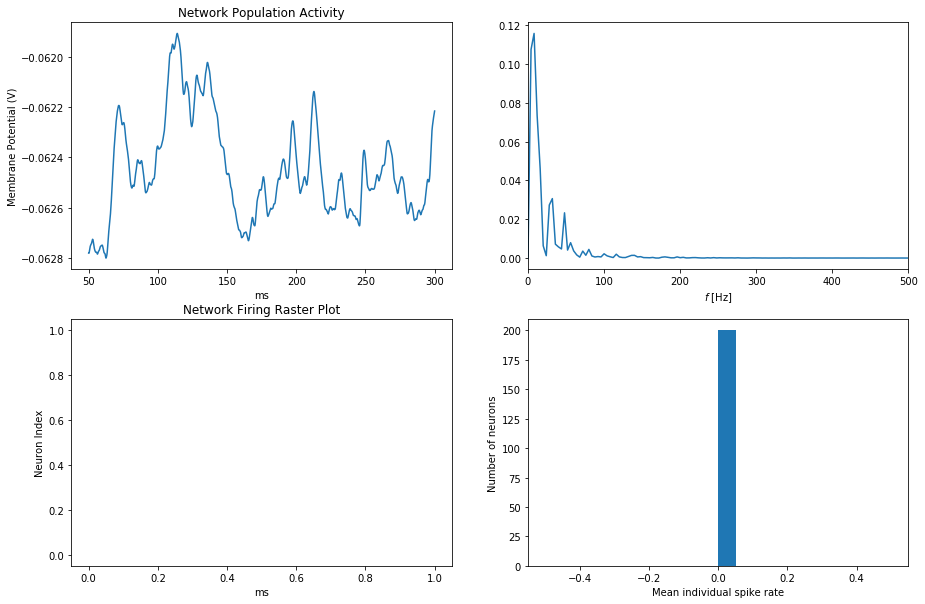

In [43]:
plot_all(T_05, v_pop_05, Rate_Mon_05, Spike_Mon_05, simulation_duration_05)

In [44]:
## 2000 Hz
start_scope()
simulation_duration_2k = 300*ms
input_freqency_2k = 2000

State_Mon_2k, Spike_Mon_2k, Rate_Mon_2k = do_simulation(simulation_duration_2k, input_freqency_2k)

T_2k = State_Mon_2k.t[1000:]/ms
v_pop_2k = np.mean(State_Mon_2k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -56.28943073 mV


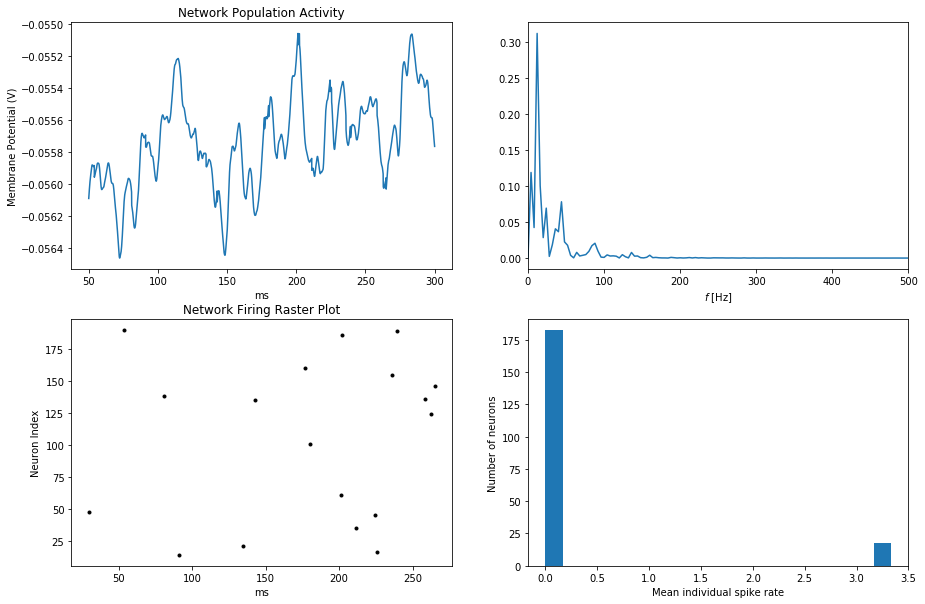

In [45]:
plot_all(T_2k, v_pop_2k, Rate_Mon_2k, Spike_Mon_2k, simulation_duration_2k)

In [49]:
## 5000 Hz
start_scope()
simulation_duration_5k = 100*ms
input_freqency_5k = 5000

State_Mon_5k, Spike_Mon_5k, Rate_Mon_5k = do_simulation(simulation_duration_5k, input_freqency_5k)

T_5k = State_Mon_5k.t[1000:]/ms
v_pop_5k = np.mean(State_Mon_5k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -59.02917717 mV


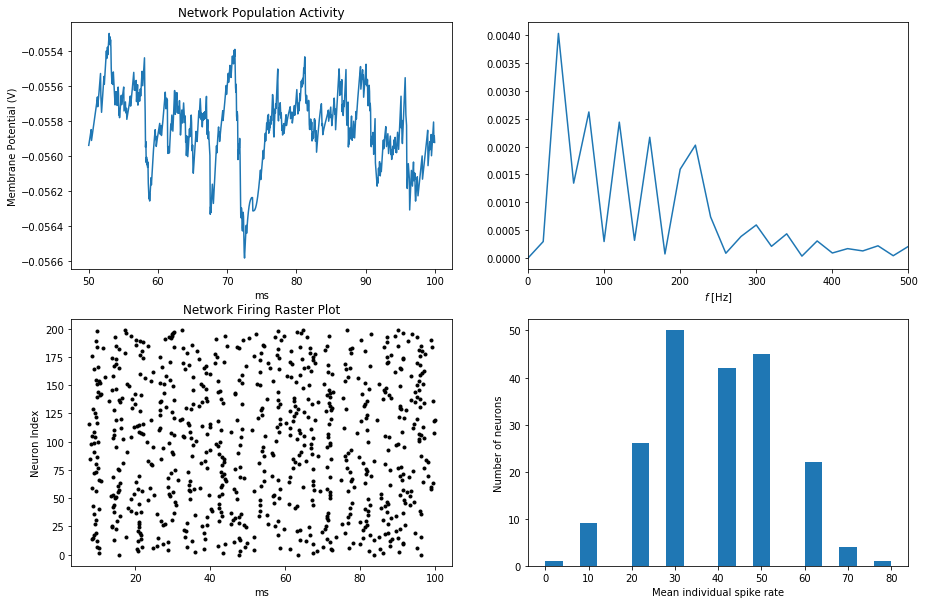

In [50]:
plot_all(T_5k, v_pop_5k, Rate_Mon_5k, Spike_Mon_5k, simulation_duration_5k)

In [118]:
## 6000 Hz
start_scope()
simulation_duration_6k = 100*ms
input_freqency_6k = 6000

State_Mon_6k, Spike_Mon_6k, Rate_Mon_6k = do_simulation(simulation_duration_6k, input_freqency_6k)

T_6k = State_Mon_6k.t[1000:]/ms
v_pop_6k = np.mean(State_Mon_6k.v , axis = 0)[1000:]     # population level average

WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Before v = -65. mV
After v = -55.01872319 mV


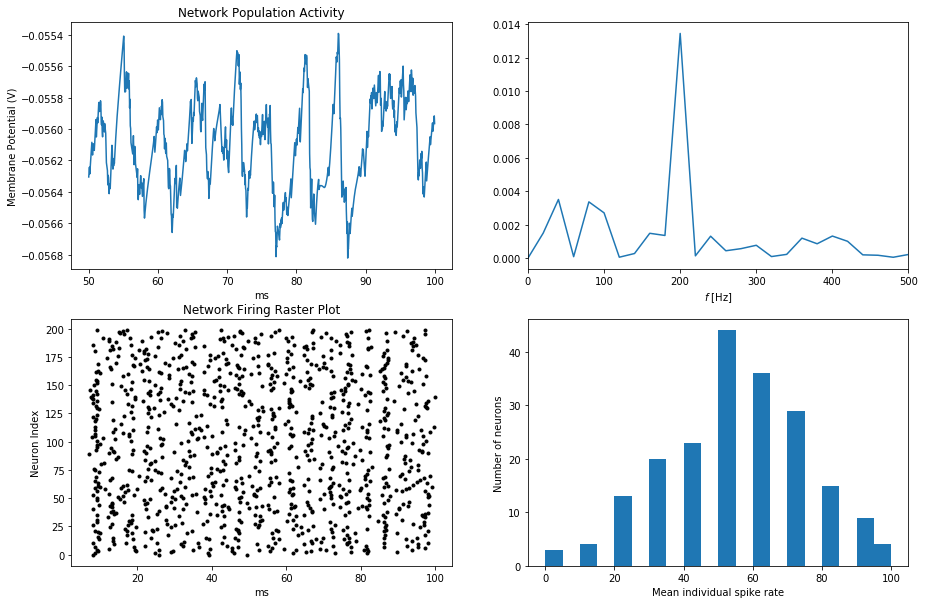

In [120]:
plot_all(T_6k, v_pop_6k, Rate_Mon_6k, Spike_Mon_6k, simulation_duration_6k)

In [121]:
## 7000 Hz
start_scope()
simulation_duration_7k = 100*ms
input_freqency_7k = 7000

State_Mon_7k, Spike_Mon_7k, Rate_Mon_7k = do_simulation(simulation_duration_7k, input_freqency_7k)

T_7k = State_Mon_7k.t[1000:]/ms
v_pop_7k = np.mean(State_Mon_7k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -54.91938059 mV


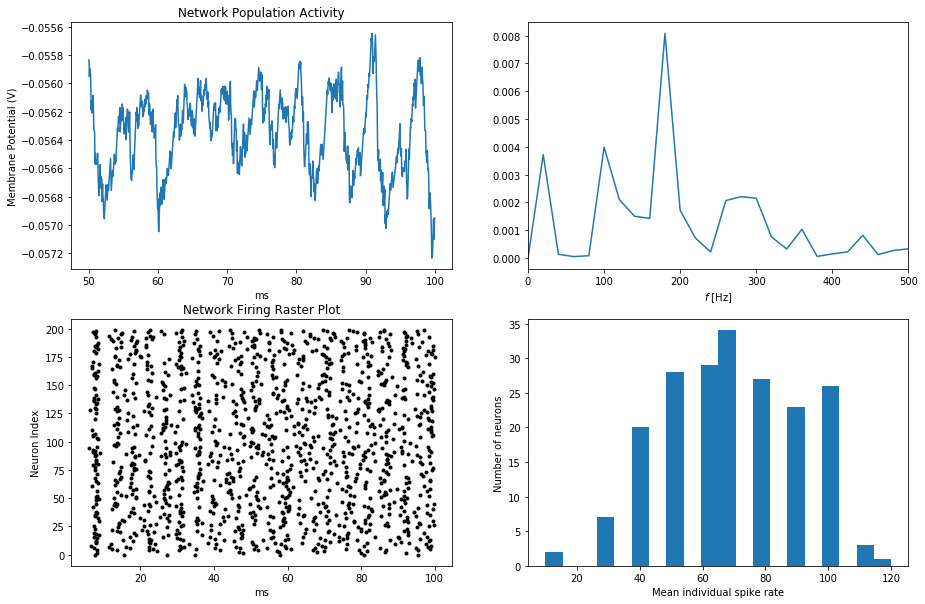

In [122]:
plot_all(T_7k, v_pop_7k, Rate_Mon_7k, Spike_Mon_7k, simulation_duration_7k)

In [123]:
## 8000 Hz
start_scope()
simulation_duration_8k = 100*ms
input_freqency_8k = 8000

State_Mon_8k, Spike_Mon_8k, Rate_Mon_8k = do_simulation(simulation_duration_8k, input_freqency_8k)

T_8k = State_Mon_8k.t[1000:]/ms
v_pop_8k = np.mean(State_Mon_8k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -55.57428051 mV


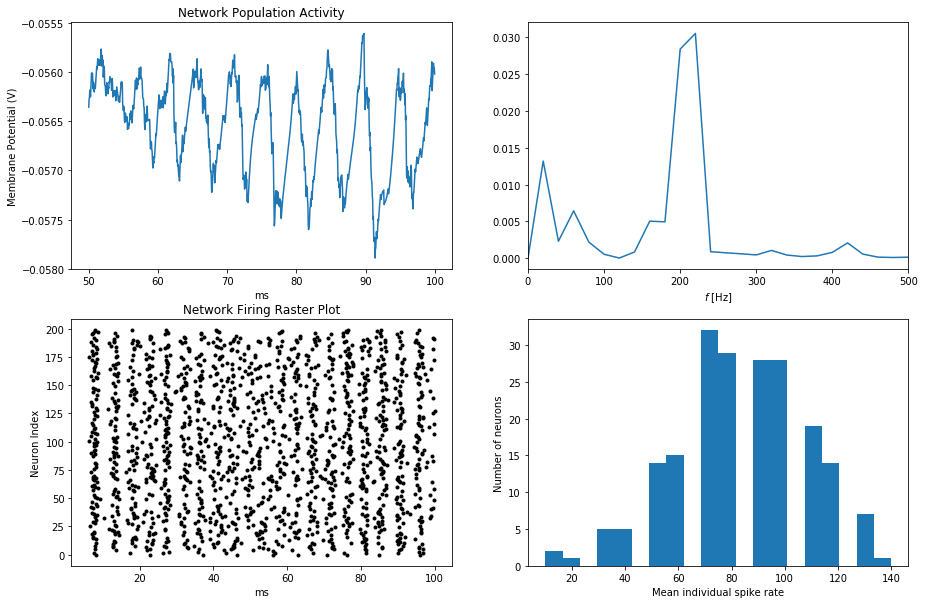

In [124]:
plot_all(T_8k, v_pop_8k, Rate_Mon_8k, Spike_Mon_8k, simulation_duration_8k)

In [53]:
## 10000 Hz
start_scope()
simulation_duration_10k = 100*ms
input_freqency_10k = 10000

State_Mon_10k, Spike_Mon_10k, Rate_Mon_10k = do_simulation(simulation_duration_10k, input_freqency_10k)

T_10k = State_Mon_10k.t[1000:]/ms
v_pop_10k = np.mean(State_Mon_10k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -58.1438568 mV


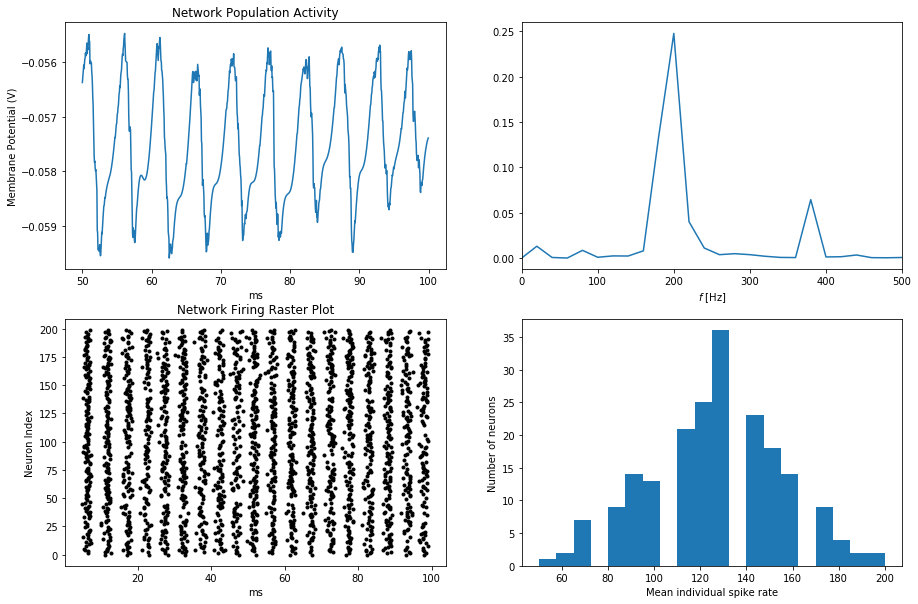

In [54]:
plot_all(T_10k, v_pop_10k, Rate_Mon_10k, Spike_Mon_10k, simulation_duration_10k)

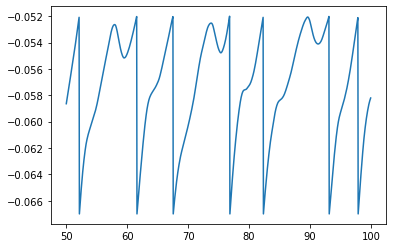

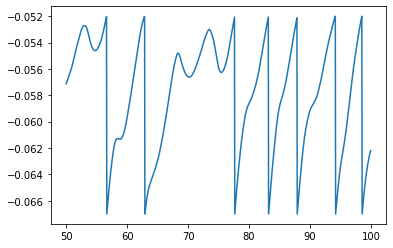

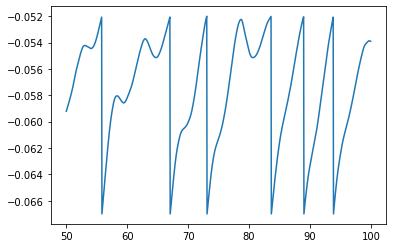

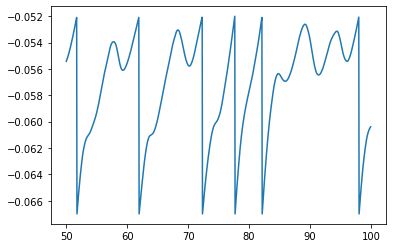

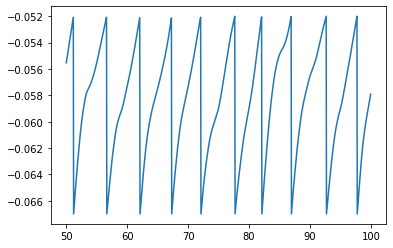

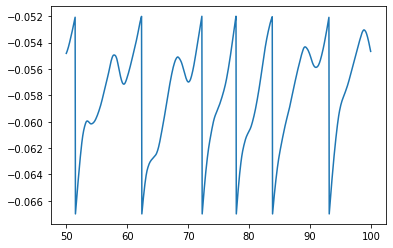

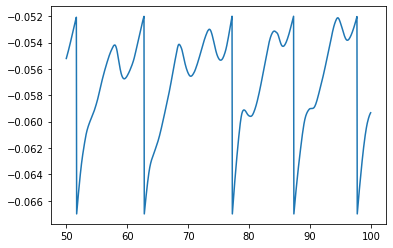

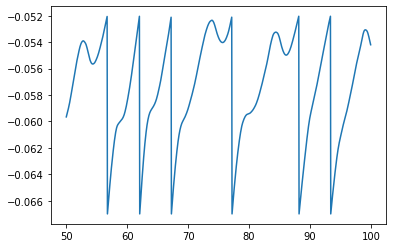

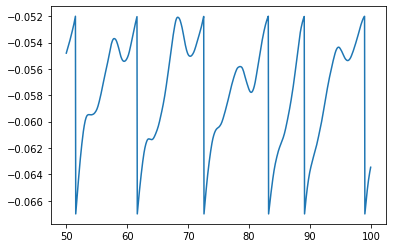

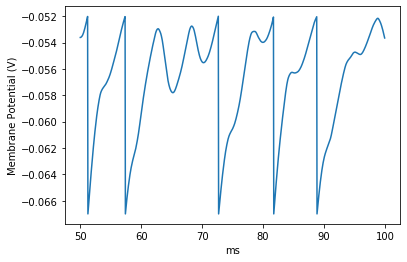

In [65]:
#plt.figure(figsize=(17,7))
for i in range(10):
    plt.figure()
    plot((State_Mon_10k.t[:]/ms)[1000:5000], (State_Mon_10k.v[i][:])[1000:5000])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.show()

In [55]:
## 15000 Hz
start_scope()
simulation_duration_15k = 100*ms
input_freqency_15k = 15000

State_Mon_15k, Spike_Mon_15k, Rate_Mon_15k = do_simulation(simulation_duration_15k, input_freqency_15k)

T_15k = State_Mon_15k.t[1000:]/ms
v_pop_15k = np.mean(State_Mon_15k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -55.55454433 mV


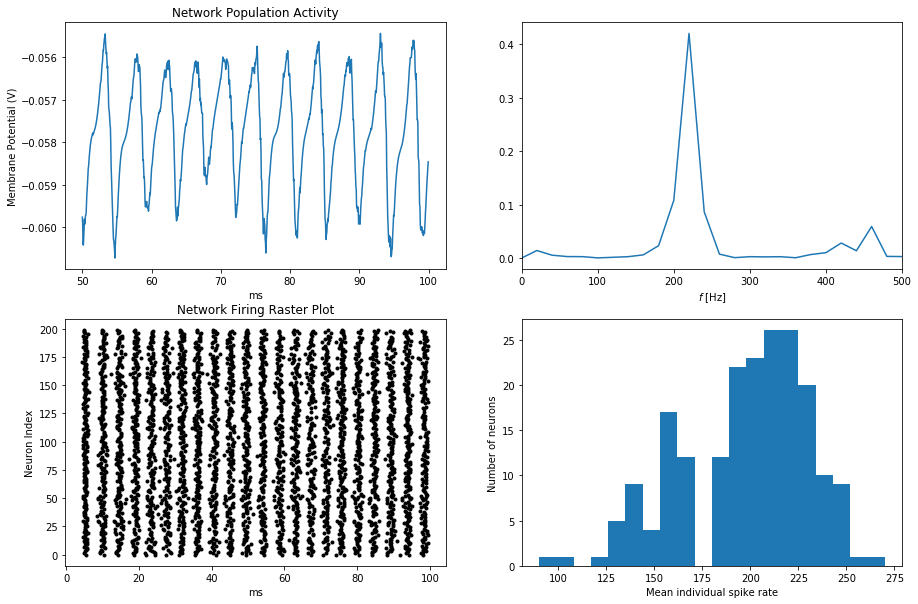

In [56]:
plot_all(T_15k, v_pop_15k, Rate_Mon_15k, Spike_Mon_15k, simulation_duration_15k)

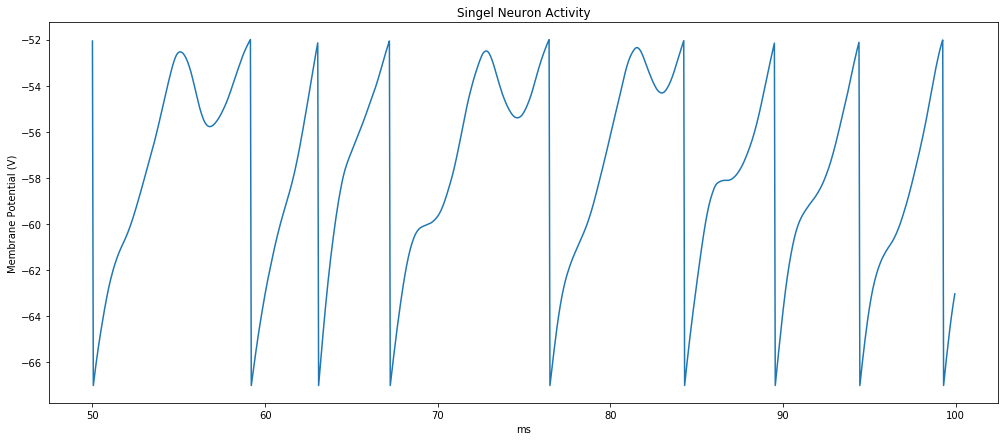

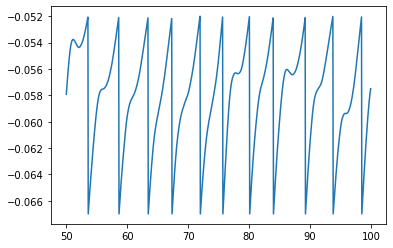

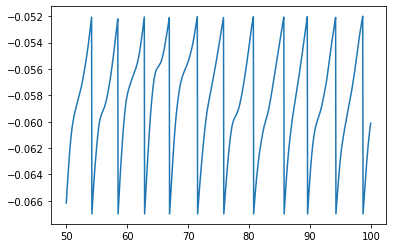

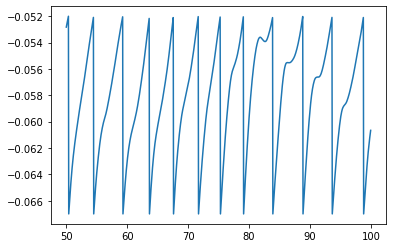

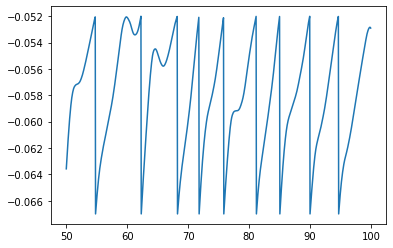

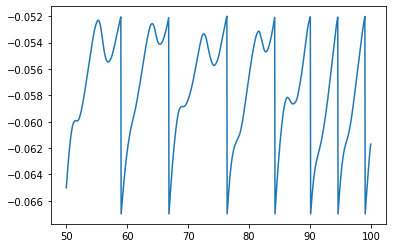

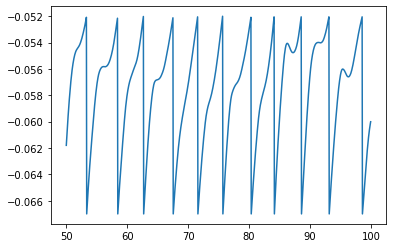

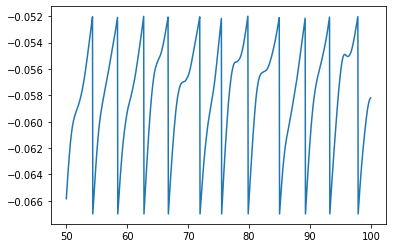

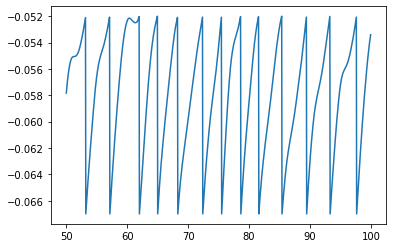

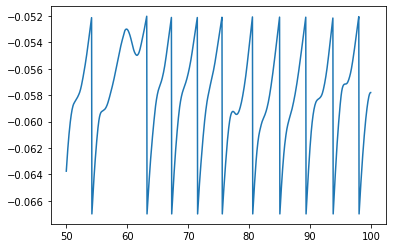

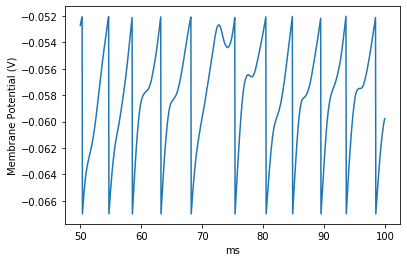

In [64]:
plt.figure(figsize=(17,7))
plot((State_Mon_15k.t[:]/ms)[1000:20000], (State_Mon_15k.v[np.random.randint(N_inhib)])[1000:20000]/mV)
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.title('Singel Neuron Activity')
plt.show()

#plt.figure(figsize=(17,7))
for i in range(10):
    plt.figure()
    plot((State_Mon_15k.t[:]/ms)[1000:5000], (State_Mon_15k.v[np.random.randint(N_inhib)][:])[1000:5000])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.show()

In [116]:
def create_spec(Spike_Mon, sim_dur, win):
    # win in ms
    window = np.arange(0, sim_dur/ms, win)#*1e3#*ms
    
    #print("w:", window)
    times=Spike_Mon.t/ms
    #print("t:", times)
    
    spikes = np.zeros(len(window))
    for i in range(1,len(spikes)):
        spikes[i]=sum((times<window[i])*1-(times<window[i-1])*1)
        
    #print(spikes)

    plt.figure()
    plt.plot(spikes[2::])
    plt.figure()
    plt.specgram(spikes-np.mean(spikes),Fs=1000/win);


WARNING    /Users/martin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=100).
 [py.warnings]


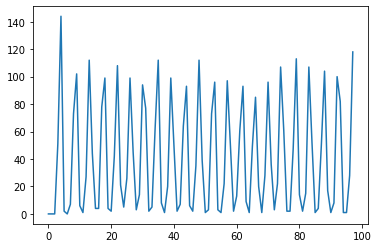

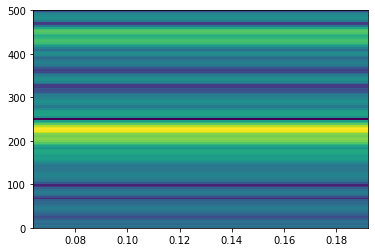

In [117]:
create_spec(Spike_Mon_15k, simulation_duration_15k, 1)

In [77]:
simulation_duration_15k

100. * msecond

In [134]:
## GABA 6000 Hz 
start_scope()
simulation_duration_G6k = 100*ms
input_freqency_G6k = 6000

State_Mon_G6k, Spike_Mon_G6k, Rate_Mon_G6k = do_simulation(simulation_duration_G6k, input_freqency_G6k, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS)

T_G6k = State_Mon_G6k.t[1000:]/ms
v_pop_G6k = np.mean(State_Mon_G6k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -55.08023211 mV


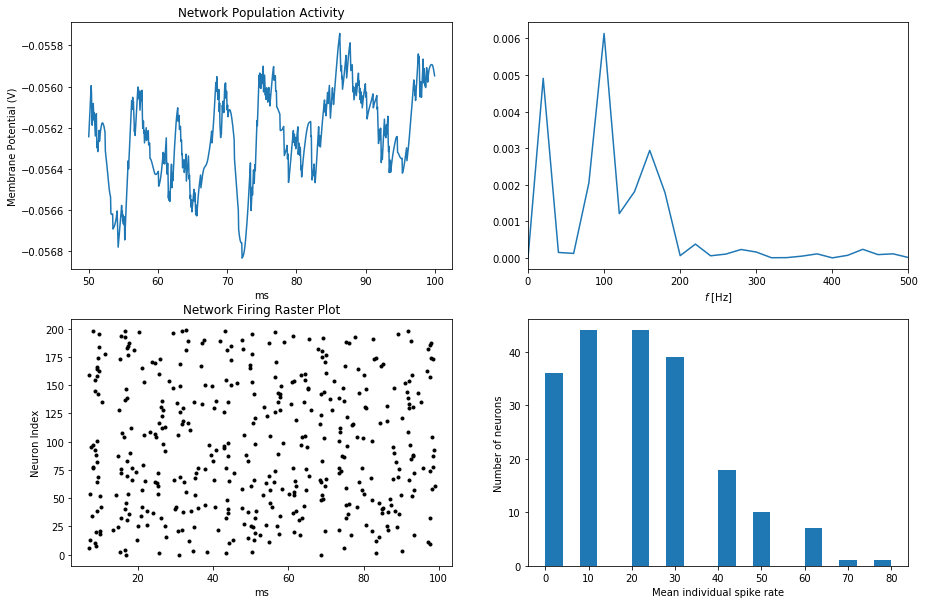

In [135]:
plot_all(T_G6k, v_pop_G6k, Rate_Mon_G6k, Spike_Mon_G6k, simulation_duration_G6k)

# sdvclnks
- less spikes, no 200Hz

In [136]:
## GABA 12000 Hz 
start_scope()
simulation_duration_G12k = 100*ms
input_freqency_G12k = 12000

State_Mon_G12k, Spike_Mon_G12k, Rate_Mon_G12k = do_simulation(simulation_duration_G12k, input_freqency_G12k, tau_d_i=2*1.2*ms, g_peak_i=2*5*nS)

T_G12k = State_Mon_G12k.t[1000:]/ms
v_pop_G12k = np.mean(State_Mon_G12k.v , axis = 0)[1000:]     # population level average

Before v = -65. mV
After v = -63.69418168 mV


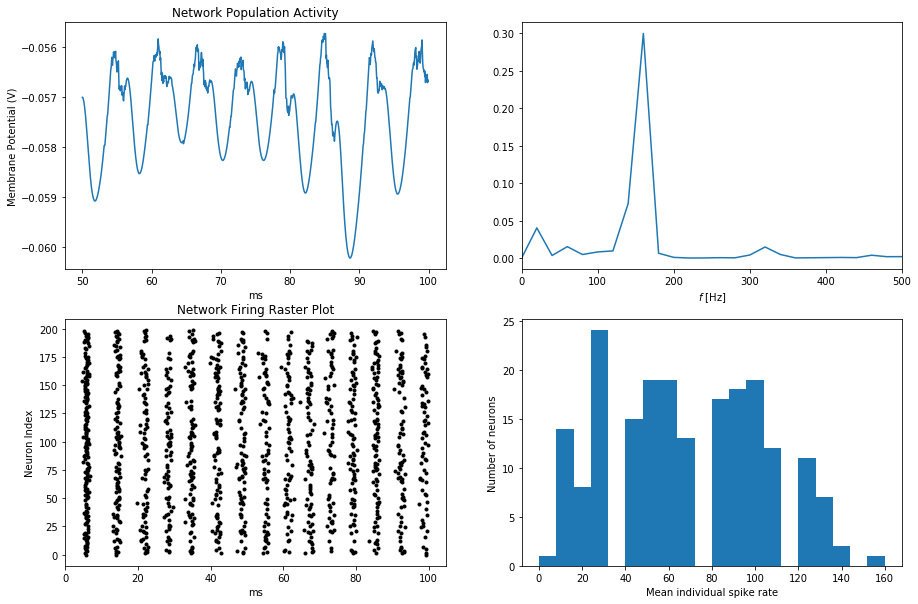

In [137]:
plot_all(T_G12k, v_pop_G12k, Rate_Mon_G12k, Spike_Mon_G12k, simulation_duration_G12k)

# smooth
# < 200 Hz
- less spikes